#  Predicting cpu/event

We use linear model and fit separately for each production task.  As one feature we use one of benchmarks (fastBmk, bogomips, hs06, whetstone) and as the second one we use input size in kb/event.

Additionally we split data per CPU name, and do simple linear fit based only on kb/event. If there is not enough measurements for a CPU type we use mean value (equivalent of dummy regressor).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


In [2]:
LReg = LinearRegression() 
#LReg.fit_intercept=False
LReg_name="linear_regression"

# LReg = Ridge(alpha = .5)
# LReg_name="ridge"


### Get datasets

In [3]:
jobs = pd.DataFrame()
input_files=['job_2017-04.csv','job_2017-05.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file).set_index('pandaid'))
jobs = pd.concat(tmp)

jobs = jobs[jobs['nevents']>20]
jobs = jobs[jobs['inputsize']>1024]

jobs['kBperEvent']= (jobs['inputsize']/1024.)/jobs['nevents']
del jobs['cputime']
del jobs['walltime']
del jobs['nevents']
del jobs['cpueff']
del jobs['wallPerEvent']
del jobs['inputsize']

jobs.head()

,hs06,processingtype,cpuPerEvent,kBperEvent
pandaid,,,,
3352703758,107,recon,4.436667,41.208089
3354732793,10,evgen,1.100000,1.727598
3326375042,96,reprocessing,12.623182,1094.765272
3327803396,77,merge,0.358200,348.054597
3330689156,90,merge,0.337855,305.437680


In [4]:
input_files=['benchmark_2017-04.csv','benchmark_2017-05.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file).set_index('pandaid'))
benchmarks = pd.concat(tmp)

print(benchmarks.columns)

del benchmarks['ip']
del benchmarks['site']
del benchmarks['meminfo']

print(benchmarks.columns)

benchmarks.head()

Index(['bogomips', 'ip', 'site', 'mpnum', 'cpuname', 'meminfo', 'fastBmk',
       'whetstone'],
      dtype='object')
Index(['bogomips', 'mpnum', 'cpuname', 'fastBmk', 'whetstone'], dtype='object')


,bogomips,mpnum,cpuname,fastBmk,whetstone
pandaid,,,,,
3322806223,5333.52,1,QEMU Virtual CPU version (cpu64-rhel6),9.223674,3195.99
3322633663,5000.00,1,Intel(R) Xeon(R) CPU E5420 @ 2.50GHz,12.129380,2749.34
3322488785,4988.06,1,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,23.731048,3599.70
3322806277,5333.16,1,Intel(R) Xeon(R) CPU X5650 @ 2.67GHz,12.240734,3426.18
3322875248,5332.58,1,Intel(R) Xeon(R) CPU E5430 @ 2.66GHz,12.349914,2911.33


### join dataframes and filter out bad rows

In [5]:
benchmarks = benchmarks.join(jobs,how='inner')
# benchmarks = benchmarks[benchmarks.cpuPerMB > 0]
# benchmarks = benchmarks[benchmarks.cpuPerEvent > 0]
benchmarks = benchmarks[benchmarks.mpnum == 1]

del benchmarks['mpnum']

benchmarks.head()

,bogomips,cpuname,fastBmk,whetstone,hs06,processingtype,cpuPerEvent,kBperEvent
pandaid,,,,,,,,
3323737831,5199.28,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.863749,3612.79,10,simul,73.644,187.893764
3323782011,5199.25,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.869888,3628.96,10,evgen,154.110,382.974707
3323782017,4189.98,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,18.136020,3306.22,10,evgen,159.280,382.974707
3323788151,5199.24,Intel(R) Xeon(R) CPU E5-2640 v3 @ 2.60GHz,20.642202,3495.29,10,evgen,167.210,382.974707
3323820043,4787.82,Intel(R) Xeon(R) CPU E5620 @ 2.40GHz,6.792453,1532.55,13,evgen,426.825,382.940435


### split over different processing types 

In [6]:
UniqueProcessingTypes = benchmarks.processingtype.unique()
print(UniqueProcessingTypes)
UniqueProcessingTypes=UniqueProcessingTypes.tolist()

UniqueProcessingTypes.remove('overlay') # only 46 measurements
UniqueProcessingTypes.remove('deriv') #

#create a dict for all the dataframes to be filled later
ProcessingType = {elem : pd.DataFrame for elem in UniqueProcessingTypes}

#filling up data frames
for key in ProcessingType.keys():
    ProcessingType[key] = benchmarks[:][benchmarks.processingtype == key]
    

['simul' 'evgen' 'reprocessing' 'merge' 'recon' 'pmerge' 'pile' 'overlay'
 'deriv']


### plot correlations

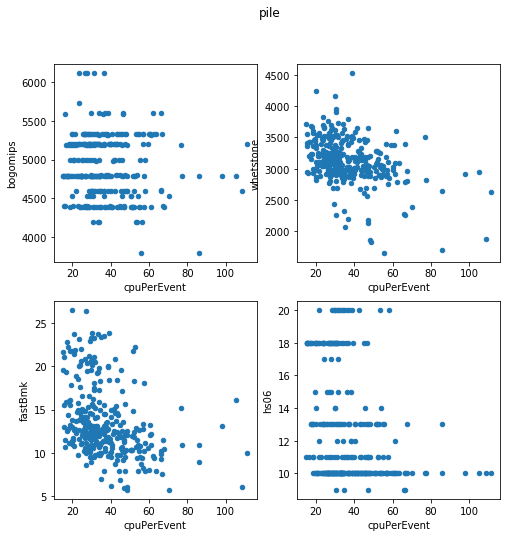

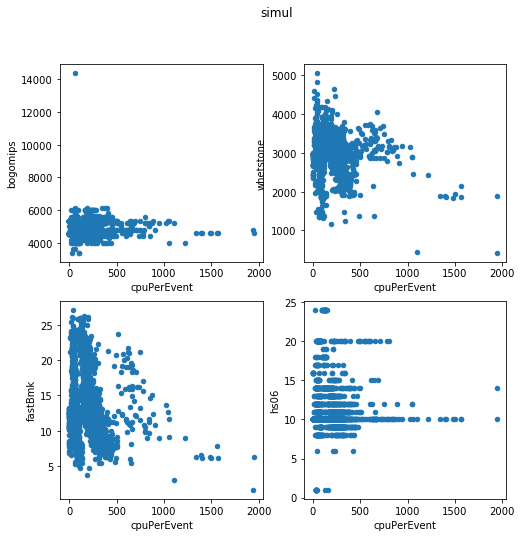

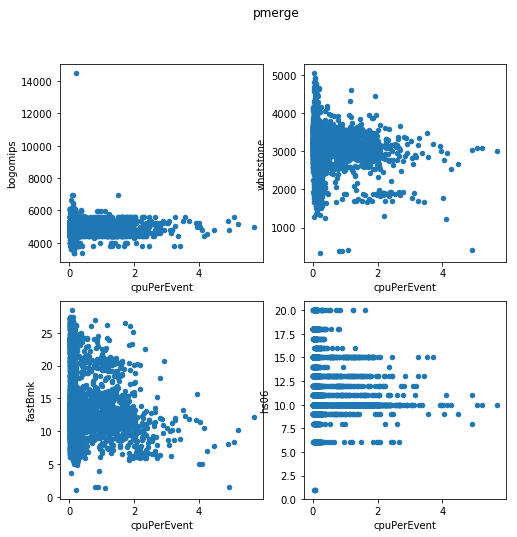

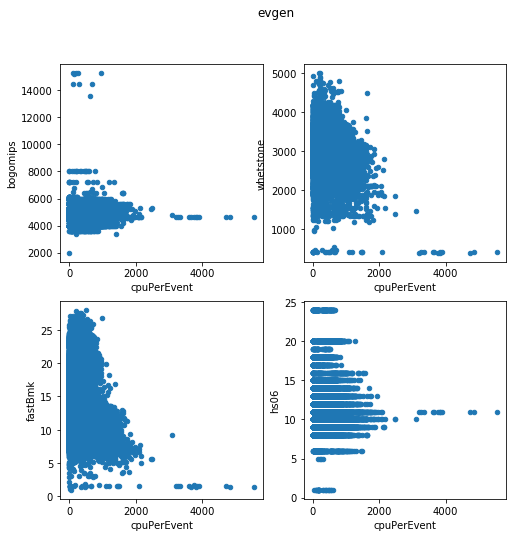

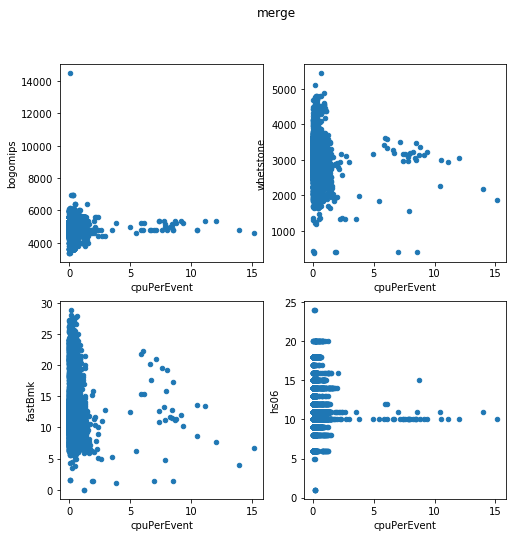

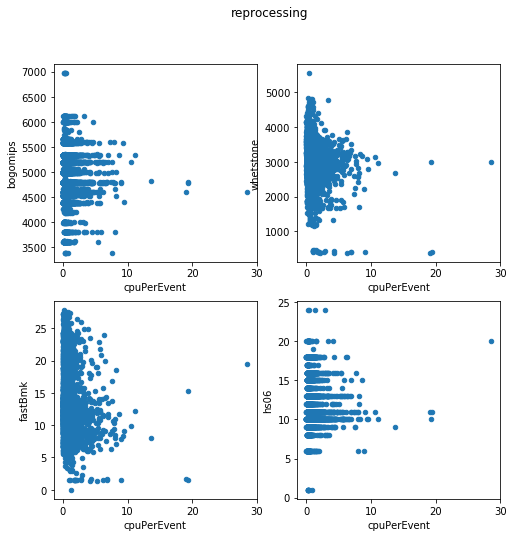

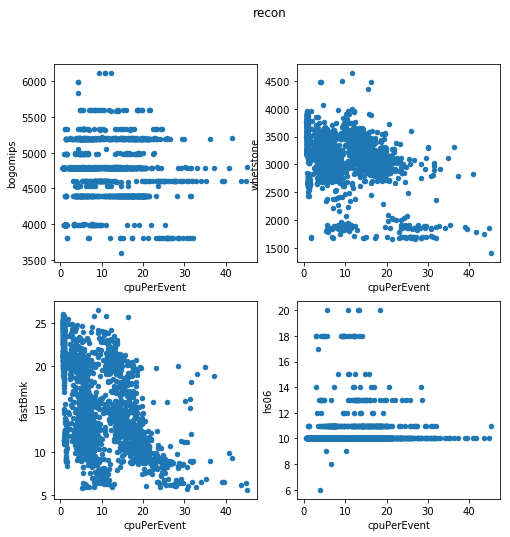

In [7]:
feat = ['bogomips', 'fastBmk', 'whetstone', 'hs06']
for pt in ProcessingType.keys():
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.suptitle(pt)
    data = ProcessingType[pt]
    for nf, f in enumerate(feat):
        i = nf%2
        j = int(nf/2)
        data.plot(ax=axes[i,j], x="cpuPerEvent", y=f, kind='scatter',figsize=(8, 8)) 

#### helpful functions

In [8]:
def correlationPlot(x1=[],y1=[],x2=[],y2=[],x3=[],y3=[],xt="x",yt="y", tit="", fit=True):
#     print ("test:",x1,y1)
#     print ("test_prediction:",x2,y2)
#     print ("Train:", x3.flatten().tolist(),y3.flatten().tolist())
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax1 = fig.add_subplot(111)
    sec = ax1.scatter(x3.flatten().tolist(), y3.flatten().tolist(), label='train',c='b')
    scp = ax1.scatter(x1, y1, label='test', c='g')
    scp = ax1.scatter(x2, y2, label='test_prediction', marker="s",c='r')
    plt.xlabel(xt)
    plt.ylabel(yt)
    plt.title(tit)
    plt.legend()
    if fit:
        lm = LReg.fit(x3, y3)
        print ("Linear model:",lm.coef_ , lm.intercept_)
        
        x_fit = np.linspace(x3[0], x3[-1], 2)
        y_fit = x_fit * lm.coef_[0][0] + lm.intercept_
        
        ax1.plot(x_fit, y_fit,'-', color='red')
        

### split on training and testing samples

In [9]:
R_mse = {}
R_r2  = {}

for pt in ProcessingType:
    print("======================== ",pt,"==============================")
    
    if pt=="merge": 
        dbg = True
    else:
        dbg = False
        
    data = ProcessingType[pt]
    tmse=[]
    tr2=[]
    #target
    y = data['cpuPerEvent'].copy()
    y = y.values.reshape(-1, 1)
    
    X=data.copy()
    del X['cpuPerEvent']
    del X['processingtype']
    #print(X.columns)
    
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=41)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    predictions={'actual':y_test.flatten()}
    errors = {}
    
    for f in feat:
        print( "*** ",f," ***")
            
        # to do cross validation 
        scores = cross_val_score(LReg, X[[f,'kBperEvent']].values, y, cv=10, scoring='r2')
        print("cross validation score: ", scores.mean())
        
        
        lm = LReg.fit(X_train[[f,'kBperEvent']].values, y_train)
        print ("Linear model:",lm.coef_ , lm.intercept_)
        #hold-out testing
        y_test_predict = lm.predict(X_test[[f,'kBperEvent']].values)
        

        errors[f] = (y_test_predict-y_test).flatten().tolist()
        predictions[f] = y_test_predict.flatten().tolist()

        evs = explained_variance_score(y_test, y_test_predict)
        mae = mean_absolute_error(y_test, y_test_predict)
        mse = mean_squared_error(y_test, y_test_predict)
        r2 = r2_score(y_test, y_test_predict) 
        print("\tevs: %2.4f" % evs, "\tmae: {:>10.4f}".format(mae), "\tmse: {:>10.4f}".format(mse), "\tr2:{:>10.4f}".format(r2)) 
        tmse.append(mae)
        tr2.append(r2)
        print("---------------------------------------")
    
    
#     fig, axes = plt.subplots(nrows=1, ncols=2)
#     plt.suptitle(pt)
#     plt.title("errors")
#     pl = pd.DataFrame(errors)
#     print("Describe residuals\n", pl.describe())
#     pl.plot(ax=axes[0], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
    
#     pl = pd.DataFrame(predictions)
#     plt.title("predictions")
#     print("Describe predictions\n", pl.describe())
#     pl.plot(ax=axes[1], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
        
    ###  based on CPU
    cdata = data.copy()
    del cdata['processingtype']
    del cdata['bogomips']
    del cdata['fastBmk']
    del cdata['whetstone']
    del cdata['hs06']
    
    UniqueCPUs = cdata.cpuname.unique()
    #print(UniqueCPUs)
    UniqueCPUs=UniqueCPUs.tolist()
    
    #create a dict for all the dataframes to be filled later
    CPUtype = {elem : pd.DataFrame for elem in UniqueCPUs}

    #filling up data frames
    for key in CPUtype.keys():
        CPUtype[key] = cdata[:][cdata.cpuname == key]
    
    allPred=[]
    allTrue=[]
    for CPU in CPUtype:
#         print("-",CPU,"-")
        cpudata = CPUtype[CPU]
        
        y = cpudata['cpuPerEvent'].copy()
        y = y.values.reshape(-1, 1)
    
        del cpudata['cpuPerEvent']
        del cpudata['cpuname']
    
        cpu_X_train,  cpu_X_test, cpu_y_train, cpu_y_test =  train_test_split( cpudata, y, test_size=0.20, random_state=41)
     #   print(cpu_X_train.shape, cpu_X_test.shape)
        
        Xtrain=cpu_X_train['kBperEvent'].values.reshape(-1, 1)
        Xtest=cpu_X_test['kBperEvent'].values.reshape(-1, 1)
        
        tr = cpu_y_test.flatten().tolist()
        allTrue += tr
        
        if cpu_X_train.shape[0]<10 or cpu_X_test.shape[0]<5 or pt=="merge": 
            print('using mean value.')
            pr=[cpu_y_test.flatten().mean()] * len(tr)
        else:
            # doing linear fit
            lm = LReg.fit(Xtrain, cpu_y_train)
            pr = lm.predict(Xtest).flatten().tolist()
            
#             if r2_score(tr, pr)<-50
            if dbg: 
                print("crazy val:",r2_score(tr, pr)," using mean", CPU)
                #print ("Linear model:",lm.coef_ , lm.intercept_)
                correlationPlot(
                        x1=Xtest.flatten().tolist(),
                        y1=tr,
                        x2=Xtest.flatten().tolist(),
                        y2=pr,
                        x3=Xtrain,
                        y3=cpu_y_train,
                        xt="kBperEvent",yt="cpuPerEvent",                             
                        tit="processing type:" + pt + "  CPU:" + CPU.strip()
                        )
        
        allPred += pr
            
    evs = explained_variance_score(allTrue, allPred)
    mae = mean_absolute_error(allTrue, allPred)
    mse = mean_squared_error(allTrue, allPred)
    r2 = r2_score(allTrue, allPred) 
    print("\tevs: %2.4f" % evs, "\tmae: {:>10.4f}".format(mae), "\tmse: {:>10.4f}".format(mse), "\tr2:{:>10.4f}".format(r2)) 
    
    tmse.append(mae)
    tr2.append(r2)
    
    R_mse[pt]=tmse
    R_r2[pt]=tr2

========================  pile ==============================
(248, 6) (248, 1) (62, 6) (62, 1)
***  bogomips  ***
cross validation score:  -0.112909425498
Linear model: [[-0.00464972 -0.00235435]] [ 85.31603786]
	evs: 0.0136 	mae:    11.8687 	mse:   241.2210 	r2:    0.0121
---------------------------------------
***  fastBmk  ***
cross validation score:  0.0446624121939
Linear model: [[ -1.33602083e+00   3.78019249e-04]] [ 51.13690446]
	evs: 0.0979 	mae:    11.2894 	mse:   220.2877 	r2:    0.0979
---------------------------------------
***  whetstone  ***
cross validation score:  0.0123515430473
Linear model: [[-0.01792238 -0.0002143 ]] [ 95.63484185]
	evs: 0.0310 	mae:    12.2044 	mse:   237.3030 	r2:    0.0282
---------------------------------------
***  hs06  ***
cross validation score:  -0.0239967883284
Linear model: [[-1.47776539 -0.00155481]] [ 72.15132148]
	evs: 0.0573 	mae:    11.9788 	mse:   230.1869 	r2:    0.0573
---------------------------------------
using mean value.
usi

### plot results

In [10]:
Results=pd.DataFrame(R_r2,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,pile,pmerge,recon,reprocessing,simul
bogomips,0.031471,0.015324,0.012143,0.380899,0.370643,0.484582,0.193028
fastBmk,0.110156,0.030976,0.097870,0.390100,0.560296,0.503543,0.238582
whetstone,0.108262,0.039723,0.028188,0.397513,0.493977,0.521362,0.222663
hs06,0.031725,0.016281,0.057331,0.382589,0.370805,0.485118,0.193972
cpu name,0.316131,0.091518,0.604962,0.441375,0.632492,0.253919,0.410340


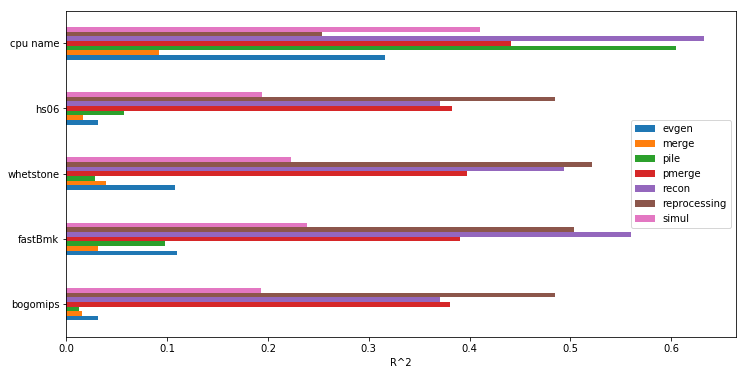

In [12]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.set_xlabel('R^2')
ax.get_figure().savefig("benchmarks_r2_"+LReg_name+"_no_constraints.png")

In [13]:
Results=pd.DataFrame(R_mse,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,pile,pmerge,recon,reprocessing,simul
bogomips,255.631337,0.271464,11.868703,0.284510,4.509359,0.250973,100.665471
fastBmk,248.937486,0.270249,11.289397,0.281201,3.456950,0.256143,101.317736
whetstone,249.978169,0.270824,12.204387,0.284579,3.976596,0.259073,100.860004
hs06,255.667689,0.272588,11.978808,0.284808,4.492060,0.250911,101.286395
cpu name,208.188453,0.261640,7.114237,0.246321,3.079057,0.270252,74.884651


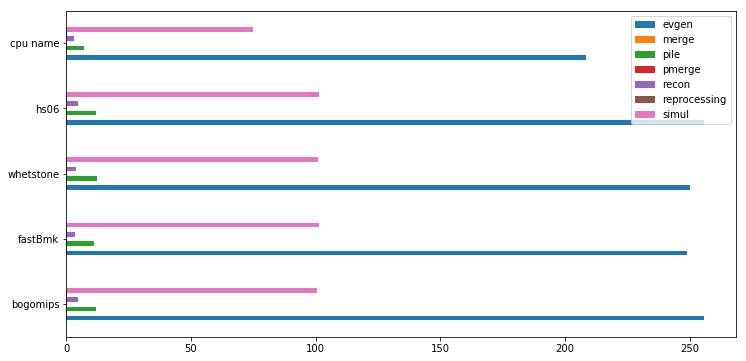

In [14]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks_mae_"+LReg_name+"_no_constraints.png")